# 영화 리뷰 감성 분석

## 필수 과제

### 1. 데이터셋 불러오기

In [1]:
import pandas as pd

df = pd.read_csv('./netflix_reviews.csv')

In [2]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,09ed2c3a-a4ca-4241-a01c-e7543943ee05,reyes Cruz,Very good experience. Great customer service.,5,0,7.89.0 build 18 35322,2024-10-20 14:10:34,7.89.0 build 18 35322
1,b2d324ff-0005-45c4-accf-dc983124400d,NISITH DISSANAYAKE (Widenn Gamer),Bro I was watching w cartoon then this error c...,1,0,8.136.0 build 3 50908,2024-10-20 14:10:25,8.136.0 build 3 50908
2,2d619b1e-aca3-4807-b77f-c9446a606ddf,Evelyn Okoro,Desent,5,0,NaN,2024-10-20 14:06:08,NaN
3,03cc29b9-a49a-4e26-885a-d1652bb669be,Yogesh Bhatta,THIS IS SCAM COMPANY.. THEY JUST LOOT PEOPLE M...,1,0,7.98.0 build 7 35414,2024-10-20 14:02:13,7.98.0 build 7 35414
4,c1b98dcf-0b75-4952-b9ac-6165381f41cf,P3L0NAZ0,Stopped opening. I've uninstalled and reinstal...,1,0,8.136.0 build 3 50908,2024-10-20 14:01:12,8.136.0 build 3 50908


In [3]:
df.tail()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
117035,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
117036,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
117037,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
117038,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346
117039,dc1352e9-10a8-41ca-ab23-05d045b08e90,suraj soni,"this app is awesome for english movies ,series...",4,0,NaN,2020-05-24 11:04:08,NaN


In [4]:
print(f'Shape of the dataset: {df.shape}')
print(f'Columns in the dataset: {df.columns}')

Shape of the dataset: (117040, 8)
Columns in the dataset: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


### 2. 데이터 전처리

In [5]:
import re  # 정규 표현식을 사용하기 위함 

# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text

# 필요한 열만 선택
df = df[['content', 'score']]

df['content'] = df['content'].apply(preprocess_text)

df.head()

,content,score
0,very good experience great customer service,5
1,bro i was watching w cartoon then this error c...,1
2,desent,5
3,this is scam company they just loot people mon...,1
4,stopped opening ive uninstalled and reinstalle...,1


### 3. feature 분석 (EDA)

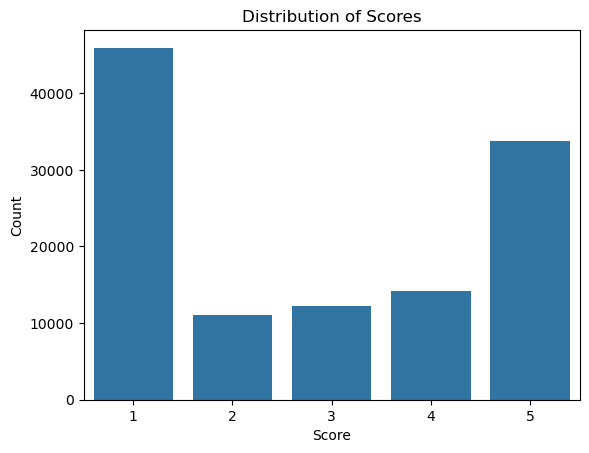

In [6]:
import seaborn as sns  # 그래프를 그리기 위한 seaborn 라이브러리 임포트 (없으면 설치 바랍니다)
import matplotlib.pyplot as plt  # 그래프 표시를 위한 pyplot 임포트

sns.countplot(x='score', data=df)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

### 4. 리뷰 예측 모델 학습시키기 (LSTM)

In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


# 데이터셋 클래스 정의
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return torch.tensor(review), torch.tensor(rating)

# 데이터셋 정의
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# 데이터 로더 정의
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded.unsqueeze(0))
        return self.fc(hidden[-1])

# 하이퍼파라미터 정의
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = len(set(ratings))  # 예측할 점수 개수

# 모델 초기화
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 모델 학습은 직접 작성해보세요!!!

# 예측 함수(예시)
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(review))
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        return label_encoder.inverse_transform([prediction])[0]

# 새로운 리뷰에 대한 예측
new_review = "This app is great but has some bugs."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

NameError: name 'train_reviews' is not defined